# Environment exceptions and helper functions

## FSM Environment Exceptions
These exceptions are thrown in case of incorrect transition/state properties of the FSM in the CSV file during the initialization and operation of the custom gym environment.

In [21]:
class FSMStartStateNotFoundError(Exception):
    """
    This exception ensures that the FSM loaded from the CSV file has any start states in case a preset one has not been provided.
    """
    def __init__(self):
        print("ERROR: No start states have been found in the CSV file!")
        print("Please recheck the file and set at least a single start state.")

In [22]:
class FSMTransitionStateNotFoundError(Exception):
    """
    This exception is thrown in case the CSV file does not contain a state that the environment was meant to transition to.
    """
    def __init__(self, unique_id):
        print("ERROR: The transition to a state of the unique ID: {} has failed due to the state not being found in the CSV file!".format(unique_id))
        print("If this was not expected, please check the CSV file.")

In [23]:
class FSMIncorrectPresetStartStateError(Exception):
    """
    This exception ensures that a correct preset state has been provided (or if it actually exists in the CSV file).
    """
    def __init__(self, unique_id):
        print("ERROR: The provided preset start state of the unique ID {} has not been found in the CSV file, or is not set as a start state.".format(unique_id))
        print("Please change the preset ID or set the state to be a start state in the CSV file.")

## CSV File Exceptions
These exceptions are thrown in case of data errors in the CSV file.

In [24]:
class CSVFileTransitionsError(Exception):
    """
    This exception ensures that the FSM loaded from the CSV file has a correct amount of transitions.
    """  
    def __init__(self, list_of_states):
        print("ERROR: States of the following Unique IDs have at least one of the following errors:")
        print("A. The amount of states in the 'Transitions_to_states' field is not equal to the amount of actions in the 'Possible_discrete_actions_(transitions)' field.")
        print("B. The amount of states in the 'Transitions_to_states' field is not equal to the amount of transitions in the 'Transition_names' field.")
        print("C. The amount of actions in the 'Possible_discrete_actions_(transitions)' field is not equal to the amount of transitions in the 'Transition_names' field.")
        print(*list_of_states)
        print("Please recheck the states and try again.")

In [25]:
class CSVFileEmptyValues(Exception):
    """
    This exception is thrown in case it contains empty values in at least one row.
    """
    def __init__(self, list_of_rows):
        print("ERROR: The following rows of the CSV file provided contain empty values:")
        print(*list_of_rows)
        print("Please recheck the CSV file.")

## Helper functions for pre-eliminary testing of the loaded CSV file
The following functions and exception help to prepare the CSV file for later use. However, they serve more as helpers rather than Q&A bug-testing methods, since they will not detect a CSV file broken beyond anything of quick repair, for example when there are mistyped types (i.e. the row 'Unique_ID' having a value of "UniqueID#01" instead of 1).

In [26]:
import pandas

def convert_state_names(file_name:str) -> None:
    """
    This function adds discretized state names in case the CSV file provided does not contain such a column.
    
    Example: On -> 1, Off -> 2, Reset -> 3, On -> 1 

    Warning: Although Pandas will by default load the CSV file in chunks to help with large file sizes, it might still crash when used on files of excessive file size (above available memory size).
    
    :param file_name: The file name of the CSV file.
    """
    df = pandas.read_csv(file_name, low_memory=True, memory_map=True)

    if 'Discretized_state_name' not in df.columns:
        state_names_dict = {}
        counter = 1
        # We use itertuples here as it is the fastest way of iterating row by row in a Pandas dataframe.
        for row in df.itertuples(index=False):
            # print(row)
            if row.State_name not in state_names_dict:
                state_names_dict[row.State_name] = counter
                # print(state_names_dict[row.State_name])
                counter += 1
        
        df['Discretized_state_name'] = df['State_name'].map(state_names_dict)
        df.to_csv(file_name, index=False)
        print("SUCCESS: Discretized state names have been added to the provided CSV file.")

    else:
        print("INFO: The CSV file provided already contains discretized state names.")

In [27]:
# Uncomment the following line to test the function for yourself:
# convert_state_names('csv_files/broken/pelican_without_dsn.csv')
convert_state_names('csv_files/pelican.csv')

INFO: The CSV file provided already contains discretized state names.


In [28]:
from csv import DictReader

def is_csv_empty(file_name:str) -> None:
    """
    This function checks if any value in each row is empty.
    
    :param file_name: The file name of the CSV file.
    """
    with open(file_name, 'r') as csv_file:
        # DictReader allows us to read each row of the CSV file as an ordered dictionary
        csv_dict_reader = DictReader(csv_file)
        empty_rows = []

        # Iterate over each row
        for count, row in enumerate(csv_dict_reader, start=2):
            for value in row.values():
                if not value:
                    # If a value is empty in a given row, append the index of it
                    empty_rows.append(count)
                    break
        
        if not empty_rows:
            print("INFO: The CSV file provided does not contain any empty values in its columns.")

        else:
            raise CSVFileEmptyValues(empty_rows)

In [29]:
# Uncomment the following line to cause the exception to happen
# is_csv_empty('csv_files/broken/blank.csv')
is_csv_empty('csv_files/pelican.csv')

INFO: The CSV file provided does not contain any empty values in its columns.


In [30]:
def has_states_with_not_matching_transitions(file_name:str) -> None:
    """
    This function checks if any state contains a not matching amount of transitions to its transition names or possible states to transition to.
    
    :param file_name: The file name of the CSV file.
    """
    with open(file_name, 'r') as csv_file:
      csv_dict_reader = DictReader(csv_file)
      broken_states = []
      broken_states_exist = False

      for row in csv_dict_reader:

        if len(row['Transitions_to_states'].split()) != int(row['Possible_discrete_actions_(transitions)']) or len(row['Transitions_to_states'].split()) != len(row['Transition_names'].split()) or int(row['Possible_discrete_actions_(transitions)']) != len(row['Transition_names'].split()):
          if broken_states_exist == False:
            broken_states_exist = True
          broken_states.append(row['Unique_ID'])
    
    if broken_states_exist == False:
      print("INFO: No states with a non-matching transition amount have been found.")
    else:
      raise CSVFileTransitionsError(broken_states)

In [31]:
# Uncomment the following line to cause the exception to happen
# has_states_with_not_matching_transitions('csv_files/broken/pelican_broken_states.csv')
has_states_with_not_matching_transitions('csv_files/pelican.csv')

INFO: No states with a non-matching transition amount have been found.


# Custom gym environment framework

## FSMEnv

In [32]:
import gym
import numpy as np
import pydot
import random
from csv import DictReader
from IPython.display import Image, display
from IPython.display import clear_output

class FSMEnv(gym.Env):
  """
  Custom environment that follows the OpenAI Gym interface.
  
  In this environment, an agent begins at a start state in a finite state machine and, by using provided transitions as its action space (which may vary), tries to learn the longest path from it without looping back to any previously visited state. 
  
  All observations are directly provided from a CSV file, but as the CSV file might not fit into memory, any operations related to the file I/O are proceeded by traversing through the CSV file row by row. 
  """

  def __init__(self, file_name:str, start_state_id:int=None, use_default_obs_space_limits:bool=False, max_row_count:int=100000):
    """
    Creates and initializes the FSM gym environment.

    :param file_name: The file name of the CSV file.
    :param start_state_id: Allows to set a preset start state. If given a value of 0, the environment will randomize the chosen start state at each reset of the environment.
    :param use_default_obs_space_limits: If false, the environment will try to scan and use the file for setting the maximum limits of the observation space. If true, the environment will use default observation space limits. WARNING: Using this option will lengthen the amount of timesteps needed to get stable training updates.
    :param max_row_count: If not using default obs space limits, this parameter allows to use them anyway in case of hitting a preset row limit.
    """
    super(FSMEnv, self).__init__()

    self.file_name = file_name
    self.start_state_id = start_state_id
    self.use_default_obs_space_limits = use_default_obs_space_limits
    self.max_row_count = max_row_count
    self.randomize_start_state = False
    self.start_states = []
    self.start_state_has_been_set = False
    
    self.rendering_init = False

    # When using a wrapper for vectorized environments, as we are "stepping" over, 
    # the environments in the venv reset automatically by themselves when an episode ends.

    # This means we are not able to access the observation of an agent
    # when the episode is already marked as "done", since the venv
    # skips over right to the beginning of the episode.
    
    # The variable below therefore allows us to access the node that has been visited
    # right before the reset in the rendering wrapper.
    self.last_node_before_reset = None
    preset_start_state = False

    # We use the helper functions here to test the CSV file and essentially 
    # crash the initialization of the environment in case the CSV file is broken.
    convert_state_names(file_name)
    is_csv_empty(file_name)
    has_states_with_not_matching_transitions(file_name)

    # If no preset start state has been declared,
    # the function will try to find such in the CSV file.
    if start_state_id is None:
      preset_start_state = False

    # If the start state parameter has been set to 0,
    # the function will try to find start states in the CSV file
    # and randomize between them when resetting the environment.
    elif int(start_state_id) == 0:
      # Although we do have "preset" a start state (of 0), we set the boolean here to false
      # to minimize the duplication of code in order to 
      # allow the function to append start states later on.
      preset_start_state = False
      self.randomize_start_state = True

    # If a preset start state has been declared,
    # the function will try to find it in the CSV file.
    else:
      preset_start_state = True
      self.start_state_id = int(start_state_id)

      with open(self.file_name, 'r') as csv_file:
        correct_preset_start_state = False
        # DictReader allows us to read each row of the CSV file as an ordered dictionary
        csv_dict_reader = DictReader(csv_file)

        # Iterate over each row. The row variable is a dict, representing a row in the CSV file
        for row in csv_dict_reader:
          if int(row['Unique_ID']) == self.start_state_id:
            # If the row has been found, and is a start state, everything is correct.
            if row['Start_state'] == '1':
              correct_preset_start_state = True
              self.start_state_has_been_set = True
              # We break the loop as we don't need to traverse further through the file
              break
        
        # If not, we raise an exception here
        if correct_preset_start_state == False:
          raise FSMIncorrectPresetStartStateError(self.start_state_id)

    # The function will proceed to the following if statement if a preset start state has been not provided,
    # in order to try to find any start states in the CSV file.
    if preset_start_state == False:
      any_start_state_found = False
      multiple_start_states = False

      with open(self.file_name, 'r') as csv_file:
        csv_dict_reader = DictReader(csv_file)

        for row in csv_dict_reader:
          # Append each start state to a list in case the user decides 
          # further on to randomize the start state at each reset of the environment
          if row['Start_state'] == '1':
            self.start_states.append(int(row['Unique_ID']))
            
            if self.start_state_has_been_set == False:
              # This boolean serves as a check to ensure there is
              # at least one start state in the CSV file.
              any_start_state_found = True
              self.start_state_has_been_set = True
              # In case there is only one start state, we set it as the default one.
              self.start_state_id = int(row['Unique_ID'])

            elif multiple_start_states == False:
              self.start_state_id = None
              multiple_start_states = True
      
        # If the user has not defined a preset start state or set the environment to
        # randomize the start state each time, and multiple start states have been found,
        # the function will ask the user to provide a start state to reset to each time, 
        # or if to set to randomize the start state.
        if multiple_start_states == True and self.randomize_start_state == False:
          print("Multiple start states have been found!")
          correct_start_state_provided = False

          while correct_start_state_provided == False:
            print("Please choose one of the found start states:")
            for unique_id in self.start_states:
              print(unique_id)
              
            print("Or input 0 to randomize the start state at each reset of the environment.")

            self.start_state_id = int(input("Provide an unique ID: "))
            
            if self.start_state_id not in self.start_states:
              # If the user provided a value of 0, the env will randomize the start states.
              if self.start_state_id == 0:
                self.start_state_has_been_set = False
                self.randomize_start_state = True
                correct_start_state_provided = True
              else:
                print("ID provided is not in the list!")
            
            else:
              # If the user has provided a single start state, we empty the start_state list 
              # for memory conservation as we do not need to store them anymore.
              self.start_states = []
              correct_start_state_provided = True
              self.start_state_has_been_set = True

      # If no start states at all have been found, an exception is thrown
      if any_start_state_found == False:
        raise FSMStartStateNotFoundError()
        
    if self.randomize_start_state == True:
      # Randomize a start state in case the user forgets to reset the env beforehand
      self.start_state_id = random.choice(self.start_states)

    if self.use_default_obs_space_limits == False:
      row_counter = 0
      self.max_amount_of_transitions = 0

      # Scan the file for the total amount of states if not using default limit
      with open(self.file_name, 'r') as csv_file:
        csv_dict_reader = DictReader(csv_file)
        for row in csv_dict_reader:
          row_counter += 1

          if int(row['Possible_discrete_actions_(transitions)']) > self.max_amount_of_transitions:
            self.max_amount_of_transitions = int(row['Possible_discrete_actions_(transitions)'])

          if row_counter >= self.max_row_count:
            # If the amount of rows exceeds the max row count,
            # default obs space limits will be used anyway
            self.use_default_obs_space_limits = True
            break
      
      if self.use_default_obs_space_limits == False:
        self.obs_limit = row_counter
      
    if self.use_default_obs_space_limits == True:
      # Set a limit here for the obs space
      self.obs_limit = 100
      # Sets a max amount of transitions that can be in the file.
      self.max_amount_of_transitions = 10
          
    self.current_unique_id_state = self.start_state_id

    # Define the action space
    # In our case, we use a Discrete gym.spaces object
    # When using an example action space of 2 discrete actions, we have two: 0 and 1 (0, n-1).
    # gym doesn't allow for a varying action space
    self.action_space = gym.spaces.Discrete(self.max_amount_of_transitions)
    # Also set the initial transitions to states for the agent
    with open(self.file_name, 'r') as csv_file:
      csv_dict_reader = DictReader(csv_file)

      for row in csv_dict_reader:
        if int(row['Unique_ID']) == self.current_unique_id_state:
          # initial_actions = int(row['Possible_discrete_actions_(transitions)'])
          # self.action_space = gym.spaces.Discrete(initial_actions)
          transitions_to_states = np.array(row['Transitions_to_states'].split(), dtype=np.int64)
          self.current_discretized_state = int(row['Discretized_state_name'])
          # We break the loop as we don't need to traverse further through the file
          break

    # Provide the agent with the discrete state names
    # rather than the Unique IDs
    discretized_transition_states = []

    with open(self.file_name, 'r') as csv_file:
      csv_dict_reader = DictReader(csv_file)

      for row in csv_dict_reader:
        for transition in transitions_to_states:
          if transition == int(row['Unique_ID']):
            discretized_transition_states.append(row['Discretized_state_name'])
    
    self.transitions_to_states = np.array(discretized_transition_states, dtype=np.int64)

    # Use the amount of states in the file if False
    if self.use_default_obs_space_limits == False:
      # Due to the differing observation types (Discrete and Box),
      # we use the Dict observation space to combine them together.
      self.observation_space = gym.spaces.Dict(
      {
          # Unfortunately, SB3 does not support the np.uint64 variable type, which means 
          # that using high=np.inf with dtype=np.int64 would give us a negative value. 
          # This had to be worked around by using numpy to provide the maximum positive value that a dtype=np.int64 may have.

          # Current discrete state obs
          # +1 in the high bound to store n+1
          'current_state': gym.spaces.Box(low=0, high=(self.obs_limit + 1), shape=(1,), dtype=np.int64),
          # Past discrete states history obs
          # +1 for the shape to account for a duplicate past state (when the agent goes to an already visited state [done status])
          'past_states': gym.spaces.Box(low=0, high=np.iinfo(np.int64).max, shape=(self.obs_limit + 1,), dtype=np.int64),
          # Available transitions to states obs
          # Uses the max amount of transitions found in the file
          'transitions_to_states': gym.spaces.Box(low=0, high=np.iinfo(np.int64).max, shape=(self.max_amount_of_transitions,), dtype=np.int64),
          # Amount of states already visited
          # Since we start at 0 after the env has had a reset,
          # there's no need to add any value.
          'amount_of_states_visited': gym.spaces.Box(low=0, high=self.obs_limit, shape=(1,), dtype=np.int64),
      })

      """
      Quick information on why the keys:
      - 'current_state'
      - 'amount_of_states_visited' 
      are not using a gym.spaces.Discrete space and use a Box space instead.

      While a Discrete space would be way more fitting (since they are using a Discrete state space),
      from what I understand they create a combination with each other obs - meaning that we 
      straight-away run out of memory when using a giant Discrete space - 1,000,000,000 is enough to crash the env down.
      gym.spaces.Discrete(np.iinfo(np.int32).max) is another example.

      Although it does work with smaller state spaces, I think it's better to leave
      the mechanism the same when working with smaller and larger state spaces.
      In any case, I leave the Discrete keys here:

      'current_state': gym.spaces.Discrete(self.obs_limit + 1),
      'amount_of_states_visited': gym.spaces.Discrete(self.obs_limit),
      """

      # These variables are initialized here in case of the user forgetting to use reset() before stepping through/predicting
      self.transitions_to_states.resize(self.max_amount_of_transitions,)
      self.past_discretized_states = np.zeros((self.obs_limit + 1,), dtype=np.int64)
      self.past_unique_id_states = np.zeros((self.obs_limit + 1,), dtype=np.int64)

    # Otherwise: 
    # Use np.int64 max for Box limits spaces
    # Where needed, base on preset obs_limit for Box shape to save on memory
    elif self.use_default_obs_space_limits == True:
      self.observation_space = gym.spaces.Dict(
      {
          # Current discrete state obs
          'current_state': gym.spaces.Box(low=0, high=np.iinfo(np.int64).max, shape=(1,), dtype=np.int64),
          # Past discrete states history obs
          'past_states': gym.spaces.Box(low=0, high=np.iinfo(np.int64).max, shape=(self.obs_limit,), dtype=np.int64),
          # Available transitions to states obs
          'transitions_to_states': gym.spaces.Box(low=0, high=np.iinfo(np.int64).max, shape=(self.obs_limit,), dtype=np.int64),
          # Amount of states already visited
          'amount_of_states_visited': gym.spaces.Box(low=0, high=np.iinfo(np.int64).max, shape=(1,), dtype=np.int64),
      })

      self.transitions_to_states.resize((self.obs_limit,))
      self.past_discretized_states = np.zeros((self.obs_limit,), dtype=np.int64)
      self.past_unique_id_states = np.zeros((self.obs_limit,), dtype=np.int64)

    # This observation also serves as a counter for the two past_states arrays
    self.amount_of_states_visited = 0
    self.last_node_before_reset = None

    print("INFO: Environment successfully initialized.")
    print("Initial action space:", self.action_space)
    print("Observation space:")
    print("- High bound of 'current_state' key: {}".format(self.observation_space['current_state'].high))
    print("- Shape of 'past_states' key: {}".format(self.observation_space['past_states'].shape))
    print("- Shape of 'transitions_to_states' key: {}".format(self.observation_space['transitions_to_states'].shape))
    print("- High bound of 'amount_of_states_visited' key: {}".format(self.observation_space['amount_of_states_visited'].high))
    # print("Total amount of states in the CSV file: {}".format(self.row_counter))
    # No longer working :P

  def reset(self) -> np.ndarray:
    """
    Resets the environment.
    :return: (np.ndarray)
    """
    # Initialize the agent at the start state
    if self.use_default_obs_space_limits == False:
      # +1 for the shape to account for a duplicate past state (when the agent goes to an already visited state [done status])
      self.past_discretized_states = np.zeros((self.obs_limit + 1,), dtype=np.int64)
      self.past_unique_id_states = np.zeros((self.obs_limit + 1,), dtype=np.int64)
    else:
      self.past_discretized_states = np.zeros((self.obs_limit,), dtype=np.int64)
      self.past_unique_id_states = np.zeros((self.obs_limit,), dtype=np.int64)

    # Counter for the past 2 arrays as well.
    # Leaving it at 0 will be a bit untrue since 
    # we have visited the starting state, but it will be better for the reward.
    self.amount_of_states_visited = 0

    if self.randomize_start_state == True:
      self.start_state_id = random.choice(self.start_states)
      # print("I am choosing random!", self.start_state_id)
    
    self.current_unique_id_state = self.start_state_id

    with open(self.file_name, 'r') as csv_file:
      csv_dict_reader = DictReader(csv_file)
      
      for row in csv_dict_reader:
        if self.start_state_id == int(row['Unique_ID']):
          self.current_discretized_state = int(row['Discretized_state_name'])
          transitions_to_states = np.array(row['Transitions_to_states'].split(), dtype=np.int64)

          self.past_discretized_states[self.amount_of_states_visited] = int(row['Discretized_state_name'])
          self.past_unique_id_states[self.amount_of_states_visited] = int(row['Unique_ID'])
          # We break the loop as we don't need to traverse further through the file
          break

    # Provide the agent with the discrete state names
    # rather than the Unique IDs
    discretized_transition_states = []

    with open(self.file_name, 'r') as csv_file:
      csv_dict_reader = DictReader(csv_file)

      for row in csv_dict_reader:
        for transition in transitions_to_states:
          if transition == int(row['Unique_ID']):
            discretized_transition_states.append(row['Discretized_state_name'])
    
    self.transitions_to_states = np.array(discretized_transition_states, dtype=np.int64)

    if self.use_default_obs_space_limits == False:
      self.transitions_to_states.resize(self.max_amount_of_transitions,)
    else:
      self.transitions_to_states.resize(self.obs_limit,)

    observation = {
      # We need to convert the integers to a numpy array for tensor flattening
      'current_state': np.array([self.current_discretized_state], dtype=np.int64),
      'past_states': self.past_discretized_states,
      'transitions_to_states': self.transitions_to_states,
      'amount_of_states_visited': np.array([self.amount_of_states_visited], dtype=np.int64), 
    }

    return observation

  def step(self, action:int):
    """
    Steps over the environment with the chosen action.
    :param action: Action (number).
    """
    # print(action)
    ### Calculate the maximum amount of transitions
    ### If not valid in the file, -1 reward and return to the same state
    
    with open(self.file_name, 'r') as csv_file:
      csv_dict_reader = DictReader(csv_file)

      for row in csv_dict_reader:
        if int(row['Unique_ID']) == self.current_unique_id_state:
          # The line below splits the string into a list that 
          # contains the unique IDs of states that are possible to transition to
          # from the current state, and uses the action integer 
          # to choose a transition from the list.
          # The int() function just converts the string to an integer.


          # Check here if amount of transitions is below the max action space
          # If yes...
            # Check if action is below the max action
            # If yes....
              # Use it
            # If not....
              # Reward 0, return to the same state
              # Do not append to past states and add anything, just finish the step
          # If not...
            # Continue as normal

          transitions = row['Transitions_to_states'].split()
          break
      
    incorrect_action_chosen = False

    if len(transitions) != self.max_amount_of_transitions:
      if action < len(transitions):
        # print("Action", action)
        # print("Max amount of transitions", self.max_amount_of_transitions)
        # print("Transitions:", transitions)
        self.current_unique_id_state = int(transitions[action])
      else:
        incorrect_action_chosen = True
    else:
      self.current_unique_id_state = int(transitions[action])

    if incorrect_action_chosen == False:
      new_state_successfully_found = False

      with open(self.file_name, 'r') as csv_file:
        csv_dict_reader = DictReader(csv_file)
        
        for row in csv_dict_reader:
          if int(row['Unique_ID']) == self.current_unique_id_state:
            new_state_successfully_found = True
            self.current_discretized_state = int(row['Discretized_state_name'])
            transitions_to_states = np.array(row['Transitions_to_states'].split(), dtype=np.int64)
            # actions = int(row['Possible_discrete_actions_(transitions)'])
            # self.action_space = gym.spaces.Discrete(actions)
            break
      
      if new_state_successfully_found == True:
        # Provide the agent with the discrete state names
        # rather than the Unique IDs
        discretized_transition_states = []

        with open(self.file_name, 'r') as csv_file:
          csv_dict_reader = DictReader(csv_file)

          for row in csv_dict_reader:
            for transition in transitions_to_states:
              if transition == int(row['Unique_ID']):
                discretized_transition_states.append(row['Discretized_state_name'])
        
        self.transitions_to_states = np.array(discretized_transition_states, dtype=np.int64)

        if self.use_default_obs_space_limits == False:
          # Resize the obs for the defined observation space
          self.transitions_to_states.resize(self.max_amount_of_transitions,)
        else:
          self.transitions_to_states.resize(self.obs_limit,)

        # print("Transitions to states when stepping:", self.transitions_to_states)
        
        self.amount_of_states_visited += 1

        if self.current_unique_id_state in self.past_unique_id_states:
          # If we already have been in the current state, the episode is done.
          # We store the last node for the rendering wrapper usage
          self.last_node_before_reset = self.current_unique_id_state
          reward = 0
          done = True
          # print(self.past_unique_id_states)
          # print(self.start_state_id)

        else:
          self.last_node_before_reset = None
          reward = self.amount_of_states_visited
          done = False

        # If we are using the default obs space limits and are hitting the max limits of the observation space,
        # we slice the arrays to remove obsolete states.
        if self.use_default_obs_space_limits == True and self.amount_of_states_visited == (self.obs_limit - 1):
          self.past_discretized_states = self.past_discretized_states[1:]
          self.past_unique_id_states = self.past_unique_id_states[1:]
          # Append the new state
          np.append(self.past_discretized_states, self.current_discretized_state)
          np.append(self.past_unique_id_states, self.current_unique_id_state)

        else:
          # Else we just change the zeroes in the arrays to the state "value"
          self.past_discretized_states[self.amount_of_states_visited] = self.current_discretized_state
          self.past_unique_id_states[self.amount_of_states_visited] = self.current_unique_id_state
          
      elif new_state_successfully_found == False:
        raise FSMTransitionStateNotFoundError(self.current_unique_id_state)

    else:
      # Fix the rendering wrapper not to draw edges if invalid action is chosen
      self.last_node_before_reset = None
      reward = 0
      done = False

    info = {
      'incorrect_action_chosen': incorrect_action_chosen,
    }

    observation = {
      'current_state': np.array([self.current_discretized_state], dtype=np.int64),
      'past_states': self.past_discretized_states,
      'transitions_to_states': self.transitions_to_states,
      'amount_of_states_visited': np.array([self.amount_of_states_visited], dtype=np.int64),
    }

    # print("Current ID: {} Action taken: {} Is done: {} Reward: {} Action space: {} Past states: {}".format(self.current_unique_id_state, action, done, reward, self.action_space, self.past_discretized_states))

    return observation, reward, done, info

  def render(self, action, done:bool, mode='visual'):
    """
    Renders the prediction of the model by drawing the nodes and taken transitions.
    Needs to render after env.reset() for proper functioning, otherwise it does not have the previous node stored.

    :param mode: Rendering mode - only visual is supported.
    :param action: Action taken.
    :param done: Whether the environment is done.
    """
    if mode == 'visual':
      if self.rendering_init == False:
        # Initialize the graph, as otherwise it would be overwritten with each call of render()
        self.rendering_init = True
        self.rendering_graph = pydot.Dot(graph_type='digraph', strict=True)
      
      if not done:
        if self.amount_of_states_visited == 0 and action == None:
          # We're at the start state
          # Store the start state as the previous node
          # Add the start state as a node
          with open(self.file_name, 'r') as csv_file:
            csv_dict_reader = DictReader(csv_file)

            for row in csv_dict_reader:
              if int(row['Unique_ID']) == self.start_state_id:
                original_name = row['State_name']
                start_state_name = original_name + " " + "[START STATE]"

                self.rendering_graph.add_node(pydot.Node(name=self.start_state_id, label=start_state_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))
                self.rendering_previous_node = self.start_state_id

        else:
            # We're going through the graph
            # Store the new node
            # Add a transition between the previous node and current one
            with open(self.file_name, 'r') as csv_file:
              csv_dict_reader = DictReader(csv_file)

              for row in csv_dict_reader:
                if int(row['Unique_ID']) == self.rendering_previous_node:
                  transition_name = row['Transition_names'].split()[action]
                if int(row['Unique_ID']) == self.current_unique_id_state:
                  original_name = row['State_name']

            self.rendering_graph.add_node(pydot.Node(name=self.current_unique_id_state, label=original_name, style="filled", fillcolor="white", fontname="Impact", fontsize="32"))
            self.rendering_graph.add_edge(pydot.Edge(self.rendering_previous_node, self.current_unique_id_state, label=transition_name, color="blue", fontname="Arial", fontsize="32"))
            self.rendering_previous_node = self.current_unique_id_state

      elif done:
        # The episode is done and the venv will reset automatically
        # Add the transition between the previous and last node before reset
        # We're using self.last_node_before_reset, as self.current_unique_id_state would
        # provide us the start state id due to the reset of the env
        with open(self.file_name, 'r') as csv_file:
          csv_dict_reader = DictReader(csv_file)

          for row in csv_dict_reader:
            if int(row['Unique_ID']) == self.rendering_previous_node:
              transition_name = row['Transition_names'].split()[action]
        
        self.rendering_graph.add_edge(pydot.Edge(self.rendering_previous_node, self.last_node_before_reset, label=transition_name, color='blue', fontname="Arial", fontsize='32'))
      
      clear_output(wait=True)
      plt = Image(self.rendering_graph.create_png())
      display(plt)

    else:
      raise NotImplementedError()

  def close(self):
    pass

## Using the SB3 check_env function
This allows us to see whether the environment has been defined correctly.

In [33]:
from stable_baselines3.common.env_checker import check_env

env = FSMEnv('csv_files/pelican.csv', start_state_id=0, use_default_obs_space_limits=False)
# If the environment doesn't follow the interface, an error will be thrown.
# Otherwise, everything is good!
check_env(env, warn=True)

INFO: The CSV file provided already contains discretized state names.
INFO: The CSV file provided does not contain any empty values in its columns.
INFO: No states with a non-matching transition amount have been found.
INFO: Environment successfully initialized.
Initial action space: Discrete(2)
Observation space:
- High bound of 'current_state' key: [7]
- Shape of 'past_states' key: (7,)
- Shape of 'transitions_to_states' key: (2,)
- High bound of 'amount_of_states_visited' key: [6]


## Sampling actions and stepping through the env
Testing if the env steps through correctly.

In [34]:
env = FSMEnv('csv_files/pelican.csv', start_state_id=1, use_default_obs_space_limits=False)
env.reset()
print("######################")
print("Action sampling test: ")
for i in range(5):
    obs, reward, done, info = env.step(env.action_space.sample()) # Sample a random action and step
    print("Reward:", reward, "Done?:", done, "Observation", obs)
env.close()

INFO: The CSV file provided already contains discretized state names.
INFO: The CSV file provided does not contain any empty values in its columns.
INFO: No states with a non-matching transition amount have been found.
INFO: Environment successfully initialized.
Initial action space: Discrete(2)
Observation space:
- High bound of 'current_state' key: [7]
- Shape of 'past_states' key: (7,)
- Shape of 'transitions_to_states' key: (2,)
- High bound of 'amount_of_states_visited' key: [6]
######################
Action sampling test: 
Reward: 1 Done?: False Observation {'current_state': array([2], dtype=int64), 'past_states': array([1, 2, 0, 0, 0, 0, 0], dtype=int64), 'transitions_to_states': array([3, 5], dtype=int64), 'amount_of_states_visited': array([1], dtype=int64)}
Reward: 2 Done?: False Observation {'current_state': array([3], dtype=int64), 'past_states': array([1, 2, 3, 0, 0, 0, 0], dtype=int64), 'transitions_to_states': array([4, 6], dtype=int64), 'amount_of_states_visited': array(

# Vectorized environment wrapper for rendering

In [35]:
class FSMWrapperError(Exception):
    """
    Throws an exception in case the rendering wrapper is not used with SubprocVecEnv (one agent per env [multithreading]),
    but rather with DummyVecEnv (multiple agents per env), which is not supported due to I/O issues.
    """
    def __init__(self):
        print("ERROR: This wrapper only works with SubprocVecEnvs due to")
        print("learning and rendering errors while running multiple environments on the same process.")
        print("Please use the create_vec_fsm_env() function to create the vectorized environment and wrap it if needed,")
        print("or, in case of wanting to use the make_vec_env() helper function from SB3,")
        print("please set the vec_env_cls parameter to SubprocVecEnv (vec_env_cls=SubprocVecEnv).")

In [36]:
import pydot
from IPython.display import Image, display
from IPython.display import clear_output
from stable_baselines3.common.vec_env.base_vec_env import VecEnv, VecEnvStepReturn, VecEnvWrapper
from stable_baselines3.common.vec_env import SubprocVecEnv

class FSMRenderingWrapper(VecEnvWrapper):
    """
    A vectorized wrapper for monitoring (usually) multiple environments
    and rendering a graph from their observations.

    More information on vectorized environments:
        https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html

    :param venv: The vectorized environment
    """

    def __init__(self, venv: VecEnv):
        """
        Creates a rendering vectorized wrapper.

        :param venv: The vectorized environment.
        """
        if type(venv) is not SubprocVecEnv:
            raise FSMWrapperError()

        super(FSMRenderingWrapper, self).__init__(venv=venv, observation_space=venv.observation_space)

        # Graph initialization.
        # The strict parameter ensures no edge or node is drawn twice
        self.rendering_graph = pydot.Dot(graph_type='digraph', strict=True)
        # This dict stores the amount of visits to nodes
        self.rendering_heatmap_dict = {}
        self.num_timesteps = 0
        self.total_amount_of_visits = 0

        self.num_envs = venv.num_envs
        # How often will the graph be rendered and drawn (i.e. num_envs=8 * 5000 = per 40000 timesteps)
        self.rendering_modulo = self.num_envs * 5000

        # The following get_attr function takes the attribute from first environment,
        # however it still gets returned as a list: 
        # therefore, it is required to use an index to get the value we need.
        # We take the index of 0 as each env has the same init attributes, 
        # and there is always at least one environment running.
        self.file_name = self.venv.get_attr('file_name', 0)[0]
        start_state_has_been_set = self.venv.get_attr('start_state_has_been_set', 0)[0]
        preset_start_state = self.venv.get_attr('start_state_id', 0)[0]
        start_states = self.venv.get_attr('start_states', 0)[0]
        randomize_start_state = self.venv.get_attr('randomize_start_state', 0)[0]

        # If the env randomizes start states,
        # we can already add all of the start states nodes to the dict
        if randomize_start_state == True:
            for start_state_id in start_states:
                self.rendering_heatmap_dict[start_state_id] = 0
        
        elif start_state_has_been_set == True:
            self.rendering_heatmap_dict[preset_start_state] = 0

        with open(self.file_name, 'r') as csv_file:
            csv_dict_reader = DictReader(csv_file)

            for row in csv_dict_reader:
                if randomize_start_state == True:
                    for start_state_id in start_states:
                        if int(row['Unique_ID']) == start_state_id:
                            original_name = row['State_name']
                            start_state_name = original_name + " " + "[START STATE]"

                            self.rendering_graph.add_node(pydot.Node(name=start_state_id, label=start_state_name, style='filled', fillcolor='white', fontname='Impact', fontsize='32'))

                elif start_state_has_been_set == True:
                    if int(row['Unique_ID']) == preset_start_state:
                        original_name = row['State_name']
                        start_state_name = original_name + " " + "[START STATE]"

                        self.rendering_graph.add_node(pydot.Node(name=preset_start_state, label=start_state_name, style='filled', fillcolor='white', fontname='Impact', fontsize='32'))

    def reset(self):
        obs = self.venv.reset()
        return obs

    def step_async(self, actions: np.ndarray) -> None:
        self.actions = actions
        self.previous_nodes = self.venv.get_attr('current_unique_id_state')
        self.venv.step_async(actions)

    def step_wait(self) -> VecEnvStepReturn:
        obs, reward, done, info = self.venv.step_wait()
        
        # print("Past history of states: ", self.venv.get_attr('past_unique_id_states', 0)[0])

        current_nodes = self.venv.get_attr('current_unique_id_state')
        new_nodes_found = []

        last_nodes_before_reset = self.venv.get_attr('last_node_before_reset')

        # print(self.rendering_heatmap_dict)
        # for info_dict in info:
        #     print(info)

        # VecEnv resets automatically when encountering the done signal
        # This means that environments that are done will reset
        # between the step_async() and step_wait() function
        # Therefore, we have to account for when an env is done and when it is not in our rendering
        
        # In theory, VecEnv provides a terminal_observation key in their info dict,
        # however since we need the self.last_node_before_reset for the env.render() function anyway
        # (which does not have access to the venv via itself), we're just going to use that instead of
        # unpacking the dict
        for info_dict, current_node, is_done, last_node_before_reset in zip(info, current_nodes, done, last_nodes_before_reset):
            if info_dict['incorrect_action_chosen'] == False:
                if is_done == True:
                    self.rendering_heatmap_dict[last_node_before_reset] += 1
                    self.total_amount_of_visits += 1
                    new_nodes_found.append(False)
                else:
                    if current_node not in self.rendering_heatmap_dict:
                        self.rendering_heatmap_dict[current_node] = 1
                        self.total_amount_of_visits += 1
                        new_nodes_found.append(True)
                    else:
                        # If already in the heatmap dict, just add 1
                        self.rendering_heatmap_dict[current_node] += 1
                        self.total_amount_of_visits += 1
                        new_nodes_found.append(False)
            else:
                new_nodes_found.append(False)
        
        # print("Previous nodes:", self.previous_nodes)
        # print("Current nodes:", current_nodes)
        # print("New nodes found?:", new_nodes_found)

        transition_names = []

        for info_dict, action, previous_node, current_node, new_node_found in zip(info, self.actions, self.previous_nodes, current_nodes, new_nodes_found):
            if info_dict['incorrect_action_chosen'] == False:
                with open(self.file_name, 'r') as csv_file:
                    # pass the file object to DictReader() to get the DictReader object
                    csv_dict_reader = DictReader(csv_file)

                    # iterate over each line as a ordered dictionary
                    for row in csv_dict_reader:

                        if int(row['Unique_ID']) == previous_node:
                            transition_name = row['Transition_names'].split()[action]
                            transition_names.append(transition_name)
                        
                        if new_node_found == True:
                            # row variable is a dictionary that represents a row in csv
                            if int(row['Unique_ID']) == current_node:
                                original_name = row['State_name']
                                # print("Original name:", original_name)

                if new_node_found == True:
                    self.rendering_graph.add_node(pydot.Node(name=current_node, label=original_name, style="filled", fillcolor="white", fontname="Impact", fontsize='32'))
                    # print(action, previous_node, current_node, new_node_found, transition_name, original_name)
            else:
                transition_names.append("")

        # VecEnv resets automatically when encountering the done signal
        # This means that environments that are done will reset
        # between the step_async() and step_wait() function
        # Therefore, we have to account for when an env is done and when it is not in our rendering
        
        # In theory, VecEnv provides a terminal_observation key in their info dict,
        # however since we need the self.last_node_before_reset for the env.render() function anyway
        # (which does not have access to the venv via itself), we're just going to use that instead of
        # unpacking the dict
        for info_dict, previous_node, current_node, transition_name, is_done, last_node_before_reset in zip(info, self.previous_nodes, current_nodes, transition_names, done, last_nodes_before_reset):
            if info_dict['incorrect_action_chosen'] == False:
                if is_done == True:
                    self.rendering_graph.add_edge(pydot.Edge(previous_node, last_node_before_reset, label=transition_name, color='blue', fontname="Arial", fontsize='32'))
                else:
                    self.rendering_graph.add_edge(pydot.Edge(previous_node, current_node, label=transition_name, color='blue', fontname="Arial", fontsize='32'))
        
        self.num_timesteps += self.num_envs

        if self.num_timesteps % self.rendering_modulo == 0:
            local_max = 0
            for node in self.rendering_graph.get_nodes():
                if self.rendering_heatmap_dict[int(node.get_name())] > local_max:
                    local_max = self.rendering_heatmap_dict[int(node.get_name())]
                
            for node in self.rendering_graph.get_nodes():
                amount_of_visits = self.rendering_heatmap_dict[int(node.get_name())]
                # Convert the range from 0.0 - local_max to 1.0 - 0.0 for heatmap colouring
                # NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
                # Simple linear mapping
                # The formula below has had the zeros removed for efficiency
                new_hsv_value = (-amount_of_visits / local_max) + 1.0
                node.set_fillcolor("0.0 0.0 {}".format(new_hsv_value))
                
                # If the brightness is equal or below to 0.5, we change the font color to white
                if new_hsv_value <= 0.5:
                    node.set_fontcolor("white")

            clear_output(wait=True)
            plt = Image(self.rendering_graph.create_png())
            display(plt)

            sum_of_visits = 0
            # Loop below uses the keys and values from the heatmap dict
            # to print the original state names and the amount of visits to each
            for key, value in self.rendering_heatmap_dict.items():
                with open(self.file_name, 'r') as csv_file:
                    csv_dict_reader = DictReader(csv_file)

                    for row in csv_dict_reader:
                        if int(row['Unique_ID']) == key:
                        # print("Unique ID in row:", row['Unique_ID'], "Self.env.current_unique_id_state:", self.env.current_unique_id_state)
                            original_name = row['State_name']
                print(original_name, value)
                sum_of_visits += value
            print("Total of correct visits:", sum_of_visits)
            print("Timesteps:", self.num_timesteps)

        return obs, reward, done, info

# Helper function for easy creation of a wrapped venv

In [37]:
from stable_baselines3.common.env_util import make_vec_env

def create_vec_fsm_env(file_name:str, num_envs:int, start_state_id:int=0, use_default_obs_space_limits:bool=False, max_row_count:int=100000, wrapped:bool=False):
    """
    Creates a vectorized FSM environment in one line, wrapped if needed. 

    :param file_name: The file name of the CSV file.
    :param num_envs: The amount of environments running at the same time. WARNING: Setting an amount above the amount of logical cores will result in a slowdown.
    :param start_state_id: Allows to set a preset start state. If given a value of 0, the environments will randomize the chosen start state at each reset of the environment.
    :param use_default_obs_space_limits: If false, the environments will try to scan and use the file for setting the maximum limits of the observation space. If true, the environments will use default observation space limits. WARNING: Using this option will lengthen the amount of timesteps needed to get stable training updates.
    :param max_row_count: If not using default obs space limits, this parameter allows to use them anyway in case of hitting a preset row limit.
    :param wrapped: Whether to use a rendering wrapper.
    """
    env = FSMEnv(file_name, start_state_id, use_default_obs_space_limits, max_row_count)
    env = make_vec_env(lambda: env, n_envs=num_envs, vec_env_cls=SubprocVecEnv)

    if wrapped == True:
        env = FSMRenderingWrapper(env)

    return env

# Testing and learning on environments:

Multiprocessing and discrete actions are only available with the use of A2C and PPO in the SB3 package.

In [38]:
from stable_baselines3 import PPO, A2C

Global variables for controlling multiple learning commands

In [39]:
GLOBAL_GAMMA = 0.999
GLOBAL_NUM_TIMESTEPS = 1000000
GLOBAL_EVAL_CALLBACK_FREQ = 2500
GLOBAL_EVAL_RUNS = 20

# Pelican FSM

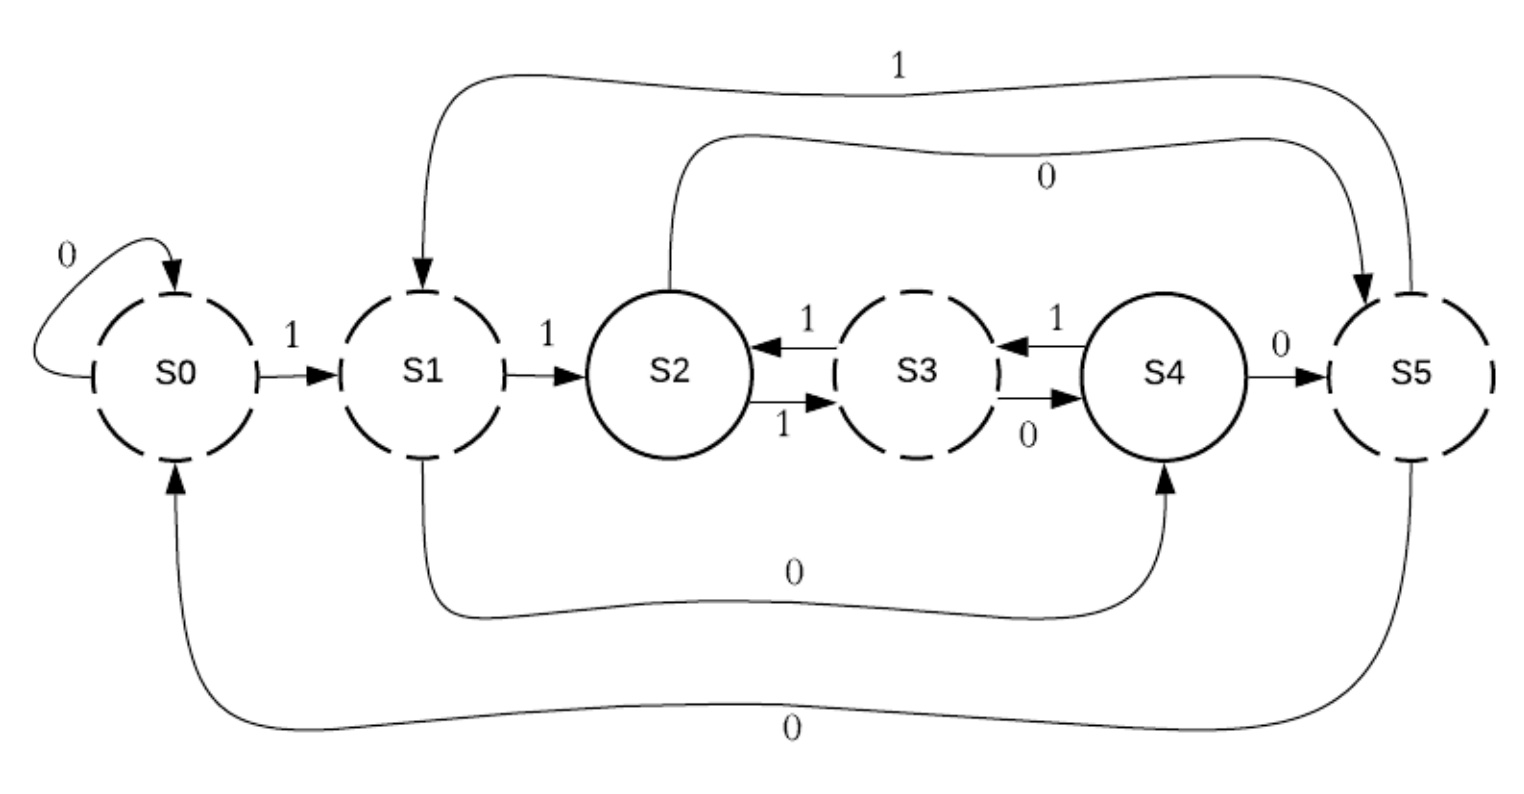

In [40]:
from IPython.display import Image
Image('original_graphs/pelican.png')

## Training on the env with supported algorithms

### A2C

Training with wrapper to render the learning process

In [ ]:
env = create_vec_fsm_env('csv_files/pelican.csv', num_envs=8, start_state_id=0, wrapped=True)

model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0).learn(GLOBAL_NUM_TIMESTEPS)

Training with EvalCallback to save best model trained using default hyperparameters

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback

env = create_vec_fsm_env('csv_files/pelican.csv', num_envs=8, start_state_id=0, wrapped=False)
eval_env = create_vec_fsm_env('csv_files/pelican.csv', num_envs=1, start_state_id=0, wrapped=False)

eval_callback = EvalCallback(eval_env, best_model_save_path='./saved_models/pelican/A2C/',
                             eval_freq=GLOBAL_EVAL_CALLBACK_FREQ, deterministic=True, render=False)

model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0).learn(GLOBAL_NUM_TIMESTEPS, callback=eval_callback)

Training with default hyperparameters for run evaluation (logs)

In [ ]:
for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/pelican/default_hyperparam/").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="A2C")

Training with tuned hyperparameters for run evaluation (logs)

In [ ]:
for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/pelican/tuned_hyperparam/").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="A2C")

Training without using knowledge about the file and tuned hyperparameters (logs)

In [ ]:
env = create_vec_fsm_env('csv_files/pelican.csv', num_envs=8, start_state_id=0, use_default_obs_space_limits=True, wrapped=False)

for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/pelican/default_obs_limits").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="A2C")

### PPO

Training with wrapper to render the learning process

In [ ]:
env = create_vec_fsm_env('csv_files/pelican.csv', num_envs=8, start_state_id=0, wrapped=True)

model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0).learn(GLOBAL_NUM_TIMESTEPS)

Training with EvalCallback to save best model trained using default hyperparameters

In [ ]:
env = create_vec_fsm_env('csv_files/pelican.csv', num_envs=8, start_state_id=0, wrapped=False)
eval_env = create_vec_fsm_env('csv_files/pelican.csv', num_envs=1, start_state_id=0, wrapped=False)

eval_callback = EvalCallback(eval_env, best_model_save_path='./saved_models/pelican/PPO/',
                             eval_freq=GLOBAL_EVAL_CALLBACK_FREQ, deterministic=True, render=False)

model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0).learn(GLOBAL_NUM_TIMESTEPS, callback=eval_callback)

Training with default hyperparameters for run evaluation (logs)

In [ ]:
for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/pelican/default_hyperparam/").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="PPO")

Training with tuned hyperparameters for run evaluation (logs)

In [ ]:
for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/pelican/tuned_hyperparam/").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="PPO")

Training without using knowledge about the file and tuned hyperparameters (logs)

In [ ]:
env = create_vec_fsm_env('csv_files/pelican.csv', num_envs=8, start_state_id=0, use_default_obs_space_limits=True, wrapped=False)

for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/pelican/default_obs_limits").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="PPO")

## PPO and A2C performance plot

# Toaster FSM

In [ ]:
Image('original_graphs/toaster.png')

## Training on the env with supported algorithms
Multiprocessing and discrete actions are only available with the use of A2C and PPO in the SB3 package.

### A2C

Training with wrapper to render the learning process

In [ ]:
env = create_vec_fsm_env('csv_files/toaster.csv', num_envs=8, start_state_id=0, wrapped=False)

model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=1).learn(GLOBAL_NUM_TIMESTEPS)

Training with EvalCallback to save best model trained using default hyperparameters

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback

env = create_vec_fsm_env('csv_files/toaster.csv', num_envs=8, start_state_id=0, wrapped=False)
eval_env = create_vec_fsm_env('csv_files/toaster.csv', num_envs=1, start_state_id=0, wrapped=False)

eval_callback = EvalCallback(eval_env, best_model_save_path='./saved_models/toaster/A2C/',
                             eval_freq=GLOBAL_EVAL_CALLBACK_FREQ, deterministic=True, render=False)

model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0).learn(GLOBAL_NUM_TIMESTEPS, callback=eval_callback)

Training with default hyperparameters for run evaluation (logs)

In [ ]:
for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/toaster/default_hyperparam/").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="A2C")

Training with tuned hyperparameters for run evaluation (logs)

In [ ]:
for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/toaster/tuned_hyperparam/").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="A2C")

Training without using knowledge about the file and tuned hyperparameters (logs)

In [ ]:
env = create_vec_fsm_env('csv_files/toaster.csv', num_envs=8, start_state_id=0, use_default_obs_space_limits=True, wrapped=False)

for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/toaster/default_obs_limits").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="A2C")

### PPO

Training with wrapper to render the learning process

In [ ]:
env = create_vec_fsm_env('csv_files/toaster.csv', num_envs=8, start_state_id=0, wrapped=True)

model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0).learn(GLOBAL_NUM_TIMESTEPS)

Training with EvalCallback to save best model trained using default hyperparameters

In [ ]:
env = create_vec_fsm_env('csv_files/toaster.csv', num_envs=8, start_state_id=0, wrapped=False)
eval_env = create_vec_fsm_env('csv_files/toaster.csv', num_envs=1, start_state_id=0, wrapped=False)

eval_callback = EvalCallback(eval_env, best_model_save_path='./saved_models/toaster/PPO/',
                             eval_freq=GLOBAL_EVAL_CALLBACK_FREQ, deterministic=True, render=False)

model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0).learn(GLOBAL_NUM_TIMESTEPS, callback=eval_callback)

Training with default hyperparameters for run evaluation (logs)

In [ ]:
for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/toaster/default_hyperparam/").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="PPO")

Training with tuned hyperparameters for run evaluation (logs)

In [ ]:
for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/toaster/tuned_hyperparam/").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="PPO")

Training without using knowledge about the file and tuned hyperparameters (logs)

In [ ]:
env = create_vec_fsm_env('csv_files/toaster.csv', num_envs=8, start_state_id=0, use_default_obs_space_limits=True, wrapped=False)

for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/toaster/default_obs_limits").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="PPO")

## PPO and A2C performance plot

# Maze FSM

- Agent cannot return on his path
- Can hit into walls
- Variable action space

## Graphs of the maze

### Maze distance graph

In [ ]:
from IPython.display import Image
Image('original_graphs/maze_distance.png')

### Maze discrete states graph

In [ ]:
Image('original_graphs/maze_discrete.png')

### Maze unique IDs graph

In [ ]:
Image('original_graphs/maze_unique_ids.png')

## Training on the env with supported algorithms
Multiprocessing and discrete actions are only available with the use of A2C and PPO in the SB3 package.

### A2C

Training with wrapper to render the learning process

In [ ]:
env = create_vec_fsm_env('csv_files/maze.csv', num_envs=8, start_state_id=0, wrapped=True)

model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0).learn(GLOBAL_NUM_TIMESTEPS)

Training with EvalCallback to save best model trained using default hyperparameters

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback

env = create_vec_fsm_env('csv_files/maze.csv', num_envs=8, start_state_id=0, wrapped=False)
eval_env = create_vec_fsm_env('csv_files/maze.csv', num_envs=1, start_state_id=0, wrapped=False)

eval_callback = EvalCallback(eval_env, best_model_save_path='./saved_models/maze/A2C/',
                             eval_freq=GLOBAL_EVAL_CALLBACK_FREQ, deterministic=True, render=False)

model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0).learn(GLOBAL_NUM_TIMESTEPS, callback=eval_callback)

Training with default hyperparameters for run evaluation (logs)

In [ ]:
for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/maze/default_hyperparam/").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="A2C")

Training with tuned hyperparameters for run evaluation (logs)

In [ ]:
for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/maze/tuned_hyperparam/").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="A2C")

Training without using knowledge about the file and tuned hyperparameters (logs)

In [ ]:
env = create_vec_fsm_env('csv_files/maze.csv', num_envs=8, start_state_id=0, use_default_obs_space_limits=True, wrapped=False)

for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = A2C('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/maze/default_obs_limits").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="A2C")

### PPO

Training with wrapper to render the learning process

In [ ]:
env = create_vec_fsm_env('csv_files/maze.csv', num_envs=8, start_state_id=0, wrapped=True)

model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0).learn(GLOBAL_NUM_TIMESTEPS)

Training with EvalCallback to save best model trained using default hyperparameters

In [ ]:
env = create_vec_fsm_env('csv_files/maze.csv', num_envs=8, start_state_id=0, wrapped=False)
eval_env = create_vec_fsm_env('csv_files/maze.csv', num_envs=1, start_state_id=0, wrapped=False)

eval_callback = EvalCallback(eval_env, best_model_save_path='./saved_models/maze/PPO/',
                             eval_freq=GLOBAL_EVAL_CALLBACK_FREQ, deterministic=True, render=False)

model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0).learn(GLOBAL_NUM_TIMESTEPS, callback=eval_callback)

Training with default hyperparameters for run evaluation (logs)

In [ ]:
for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/maze/default_hyperparam/").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="PPO")

Training with tuned hyperparameters for run evaluation (logs)

In [ ]:
for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/maze/tuned_hyperparam/").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="PPO")

Training without using knowledge about the file and tuned hyperparameters (logs)

In [ ]:
env = create_vec_fsm_env('csv_files/maze.csv', num_envs=8, start_state_id=0, use_default_obs_space_limits=True, wrapped=False)

for count, run in enumerate(GLOBAL_EVAL_RUNS):
    print("Training model run #", count)
    model = PPO('MultiInputPolicy', env, gamma=GLOBAL_GAMMA, verbose=0, tensorboard_log="./training_logs/maze/default_obs_limits").learn(GLOBAL_NUM_TIMESTEPS, tb_log_name="PPO")

## PPO and A2C performance plot

# What's left:
- Add default obs to check how they go
- Add gamma 0.8 and 0.99
- Do small hyperparameter changes
- Run the trainings (FIRST FIX THE FILENAMES ETC.)
- Plot results